<a href="https://colab.research.google.com/github/franlin1860/llm/blob/main/function_calling_agent_v040818.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow for a Function Calling Agent

This notebook walks through setting up a `Workflow` to construct a function calling agent from scratch.

Function calling agents work by using an LLM that supports tools/functions in its API (OpenAI, Ollama, Anthropic, etc.) to call functions an use tools.

Our workflow will be stateful with memory, and will be able to call the LLM to select tools and process incoming user messages.

# 防断开

In [1]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button");
     btn.click()
     }

   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect");
     btn.click()
     }
  }

setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [ ]:
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);


In [2]:
!pip install -U llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.4/362.4 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfull

In [3]:
import os

os.environ["DEEPSEEK_API_KEY"] = "sk-"

### async workflow

Since workflows are async first, this all runs fine in a notebook. If you were running in your own code, you would want to use `asyncio.run()` to start an async event loop if one isn't already running.

```python
async def main():
    <async code>

if __name__ == "__main__":
    import asyncio
    asyncio.run(main())
```

# LLM Setup

In [4]:
!pip install llama_index-llms-openai_like
!pip install llama_index-embeddings-huggingface

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [5]:
import os
import logging
import sys
from llama_index.llms.openai_like import OpenAILike
from llama_index.core import Settings, ServiceContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# 配置日志
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# 定义DeepSpeed model
llm = OpenAILike(model="deepseek-chat",
                 api_base="https://api.deepseek.com/v1",
                 api_key=os.environ["DEEPSEEK_API_KEY"],
                 temperature=0.6,
                 is_chat_model=True)

# 配置环境
Settings.llm = llm

# 设置嵌入模型
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-zh-v1.5")
Settings.embed_model = embed_model
Settings.chunk_size = 256
service_context = ServiceContext.from_defaults(
    llm=llm, embed_model=embed_model
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/95.8M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-5-f86546c39a13>:25: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


## Designing the Workflow

An agent consists of several steps
1. Handling the latest incoming user message, including adding to memory and getting the latest chat history
2. Calling the LLM with tools + chat history
3. Parsing out tool calls (if any)
4. If there are tool calls, call them, and loop until there are none
5. When there is no tool calls, return the LLM response

### The Workflow Events

To handle these steps, we need to define a few events:
1. An event to handle new messages and prepare the chat history
2. An event to trigger tool calls
3. An event to handle the results of tool calls

The other steps will use the built-in `StartEvent` and `StopEvent` events.

In [6]:
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import ToolSelection, ToolOutput
from llama_index.core.workflow import Event


class InputEvent(Event):
    input: list[ChatMessage]


class ToolCallEvent(Event):
    tool_calls: list[ToolSelection]


class FunctionOutputEvent(Event):
    output: ToolOutput

### The Workflow Itself

With our events defined, we can construct our workflow and steps.

Note that the workflow automatically validates itself using type annotations, so the type annotations on our steps are very helpful!

In [7]:
from typing import Any, List
from llama_index.core.llms.function_calling import FunctionCallingLLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.tools.types import BaseTool
from llama_index.core.workflow import Workflow, StartEvent, StopEvent, step


class FuncationCallingAgent(Workflow):
    def __init__(
        self,
        *args: Any,
        llm: FunctionCallingLLM | None = None,
        tools: List[BaseTool] | None = None,
        **kwargs: Any,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.tools = tools or []

        self.llm = Settings.llm

        self.memory = ChatMemoryBuffer.from_defaults(llm=llm)
        self.sources = []

    @step()
    async def prepare_chat_history(self, ev: StartEvent) -> InputEvent:
        # clear sources
        self.sources = []

        # get user input
        user_input = ev.input
        user_msg = ChatMessage(role="user", content=user_input)
        self.memory.put(user_msg)

        # get chat history
        chat_history = self.memory.get()
        return InputEvent(input=chat_history)

    @step()
    async def handle_llm_input(
        self, ev: InputEvent
    ) -> ToolCallEvent | StopEvent:
        chat_history = ev.input

        response = await self.llm.achat_with_tools(
            self.tools, chat_history=chat_history
        )
        self.memory.put(response.message)

        tool_calls = self.llm.get_tool_calls_from_response(
            response, error_on_no_tool_call=False
        )

        if not tool_calls:
            return StopEvent(
                result={"response": response, "sources": [*self.sources]}
            )
        else:
            return ToolCallEvent(tool_calls=tool_calls)

    @step()
    async def handle_tool_calls(self, ev: ToolCallEvent) -> InputEvent:
        tool_calls = ev.tool_calls
        tools_by_name = {tool.metadata.get_name(): tool for tool in self.tools}

        tool_msgs = []

        # call tools -- safely!
        for tool_call in tool_calls:
            tool = tools_by_name.get(tool_call.tool_name)
            additional_kwargs = {
                "tool_call_id": tool_call.tool_id,
                "name": tool.metadata.get_name(),
            }
            if not tool:
                tool_msgs.append(
                    ChatMessage(
                        role="tool",
                        content=f"Tool {tool_call.tool_name} does not exist",
                        additional_kwargs=additional_kwargs,
                    )
                )
                continue

            try:
                tool_output = tool(**tool_call.tool_kwargs)
                self.sources.append(tool_output)
                tool_msgs.append(
                    ChatMessage(
                        role="tool",
                        content=tool_output.content,
                        additional_kwargs=additional_kwargs,
                    )
                )
            except Exception as e:
                tool_msgs.append(
                    ChatMessage(
                        role="tool",
                        content=f"Encountered error in tool call: {e}",
                        additional_kwargs=additional_kwargs,
                    )
                )

        for msg in tool_msgs:
            self.memory.put(msg)

        chat_history = self.memory.get()
        return InputEvent(input=chat_history)

And thats it! Let's explore the workflow we wrote a bit.

`prepare_chat_history()`:
This is our main entry point. It handles adding the user message to memory, and uses the memory to get the latest chat history. It returns an `InputEvent`.

`handle_llm_input()`:
Triggered by an `InputEvent`, it uses the chat history and tools to prompt the llm. If tool calls are found, a `ToolCallEvent` is emitted. Otherwise, we say the workflow is done an emit a `StopEvent`

`handle_tool_calls()`:
Triggered by `ToolCallEvent`, it calls tools with error handling and returns tool outputs. This event triggers a **loop** since it emits an `InputEvent`, which takes us back to `handle_llm_input()`

## Run the Workflow!

**NOTE:** With loops, we need to be mindful of runtime. Here, we set a timeout of 120s.

In [11]:
from llama_index.core.tools import FunctionTool


def add(x: int, y: int) -> int:
    """Useful function to add two numbers."""
    return x + y


def multiply(x: int, y: int) -> int:
    """Useful function to multiply two numbers."""
    return x * y


tools = [
    FunctionTool.from_defaults(add),
    FunctionTool.from_defaults(multiply),
]

agent = FuncationCallingAgent(
    llm=Settings.llm, tools=tools, timeout=120, verbose=True
)

ret = await agent.run(input="Hello!")

Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent


In [12]:
print(ret["response"])

assistant: Hello! How can I assist you today?


In [14]:
ret = await agent.run(input="What is (2123 + 2321) * 312?")

Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent


In [15]:
print(ret["response"])

assistant: The final result of (2123 + 2321) * 312 is 1386528.


#  Dynamic function

In [8]:
# 在系统中设置了环境变量
os.environ['DYNAMIC_FUNCTIONS'] = '{"functions": [{"name": "subtract", "params": ["x", "y"], "body": "return x - y", "docstring": "Useful function to subtract two numbers."}]}'

In [9]:
import os
import json
from types import FunctionType
from llama_index.core.tools import FunctionTool

# 假设已经在系统中设置了环境变量
# os.environ['DYNAMIC_FUNCTIONS'] = '{"functions": [{"name": "subtract", "params": ["x", "y"], "body": "return x - y", "docstring": "Useful function to subtract two numbers."}]}'

def load_functions_from_env(env_var_name):
    functions = []

    # 从环境变量中获取 JSON 字符串
    json_str = os.getenv(env_var_name)
    if not json_str:
        raise ValueError(f"No data found in environment variable {env_var_name}")

    # 解析 JSON 字符串
    function_definitions = json.loads(json_str).get('functions', [])

    for func_def in function_definitions:
        name = func_def['name']
        params = func_def['params']
        body = func_def['body']
        docstring = func_def.get('docstring', "")

        # 动态创建函数的代码
        func_code = f"def {name}({', '.join(params)}):\n"
        func_code += f"    \"\"\"{docstring}\"\"\"\n"
        func_code += f"    {body}\n"

        # 定义局部变量字典
        local_vars = {}

        # 执行代码动态生成函数
        exec(func_code, {}, local_vars)

        # 从局部变量中取出生成的函数
        func = local_vars[name]
        functions.append(func)

    return functions

# 加载动态定义的函数
dynamic_functions = load_functions_from_env('DYNAMIC_FUNCTIONS')

# 封装为工具
tools = [FunctionTool.from_defaults(func) for func in dynamic_functions]

# 如果需要，可以添加更多静态定义的工具
# tools.extend([FunctionTool.from_defaults(add), FunctionTool.from_defaults(multiply)])

# 示例：使用生成的减法工具
subtract_tool = tools[0]  # 取出 subtract 工具
result = subtract_tool(10, 5)
print(result)  # 输出 5


5


In [13]:
ret = await agent.run(input="What is (10 - 5) ?")

print(ret["response"])

Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent
assistant: The result of \(10 - 5\) is \(5\).


# Show workflow

In [24]:
!pip install pyvis

In [26]:
from llama_index.core.workflow import draw_all_possible_flows

draw_all_possible_flows(FuncationCallingAgent, filename="function_calling_agent_workflow.html")

function_calling_agent_workflow.html


<ipython-input-26-d6642af9278f>:3: DeprecationWarning: Call to deprecated function (or staticmethod) draw_all_possible_flows. (Install `llama-index-utils-workflow` and use the import `from llama_index.utils.workflow` instead.)
  draw_all_possible_flows(FuncationCallingAgent, filename="function_calling_agent_workflow.html")


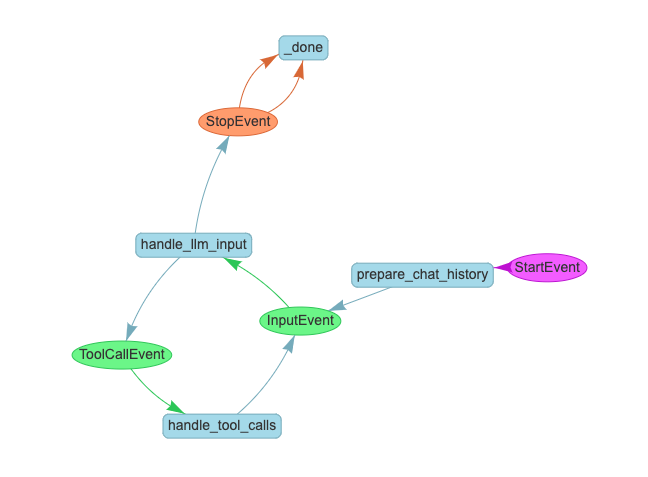